# Parallel image segmentation using multi-threading and k-means algorithm

In [1]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import time

In [2]:
image = cv2.imread('dog-pic.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Split the image into Parts :

In [3]:
def split_image(image, num_parts):
    height, width, _ = image.shape
    part_height = height // num_parts
    image_parts = []
    
    for i in range(num_parts):
        start = i * part_height
        if i == num_parts - 1:  # Last part gets the remaining part of the image
            end = height
        else:
            end = (i + 1) * part_height
        image_parts.append(image[start:end, :])
    
    return image_parts

### Merge the image parts

In [4]:
def merge_image_parts(image_parts):
    return np.vstack(image_parts)

### Apply K-Means clustering to an image segment

In [5]:
def kmeans_clustering(img, k):
    pixel_values = img.reshape((-1, 3)) # reshape image to a 2D array of pixels
    pixel_values = np.float32(pixel_values)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    _, labels, (centroids) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    centroids = np.uint8(centroids)  # convert to 8-bit color
    segmented_img = centroids[labels.flatten()]  # Map each pixel to the centroid
    
    segmented_img = segmented_img.reshape(img.shape) # reshape to the original image dimensions
    return segmented_img

In [6]:
def parallel_kmeans(image, k=3, num_parts=4, output_file='segmented_image.jpg'):

    start = time.time()

    image_parts = split_image(image, num_parts)
    
    # process each image part in parallel using Threadpool
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda part: kmeans_clustering(part, k), image_parts))
    
    segmented_image_parallel = merge_image_parts(results)

    print("Parallel K-means image segmentation : ", time.time() - start)
    
    # export the segmented image
    # cv2.imwrite(output_file, segmented_image_parallel)
    # print(f"Segmented image saved as {output_file}")

    return segmented_image_parallel

### Compare the difference in time

In [7]:
parallel_kmeans_image = parallel_kmeans(image, k=3, num_parts=4)

Parallel K-means image segmentation :  8.89914584159851


In [8]:
start_kmeans = time.time()
normal_kmeans_image = kmeans_clustering(image, 3)
print("ٔNormal K-means image segmentation : ", time.time() - start_kmeans)

ٔNormal K-means image segmentation :  22.475411891937256


### Plot the original image and segmented images

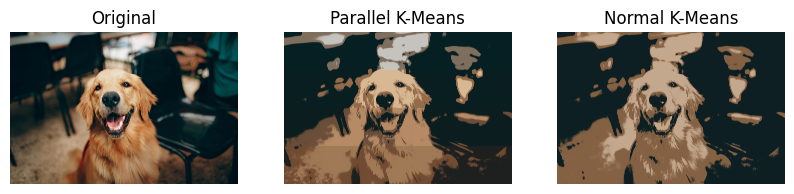

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original')
plt.axis('off')

parallel_kmeans_image_rgb = cv2.cvtColor(parallel_kmeans_image, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 2)
plt.imshow(parallel_kmeans_image_rgb)
plt.title('Parallel K-Means')
plt.axis('off')

normal_kmeans_image_rgb = cv2.cvtColor(normal_kmeans_image, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 3)
plt.imshow(normal_kmeans_image_rgb)
plt.title('Normal K-Means')
plt.axis('off')

plt.show()